# Capstone Part 4.1 - Data Preprocessing / K nearest neighbour Modelling

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plotly.express as px


In [2]:
combhotel_clean_df = pd.read_csv('combhotel_clean_df_v2.csv')

In [3]:
combhotel_clean_df.sample(3)

,hotel,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,IsCanceled,ADR_bin,got_assigned_room
85512,city hotel,69,2017,August,31,5,2,2,2,0,...,Transient,114.80,0,0,Check-Out,2017-08-09,2017-08-05,False,101-150,True
66962,city hotel,203,2016,August,34,17,0,3,2,1,...,Transient,87.99,0,0,Check-Out,2016-08-20,2016-08-17,False,51-100,True
80205,city hotel,0,2017,May,19,7,2,0,2,0,...,Transient,130.00,0,0,Check-Out,2017-05-09,2017-05-07,False,101-150,True


In [4]:
combhotel_clean_df.columns

Index(['hotel', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDate', 'IsCanceled', 'ADR_bin', 'got_assigned_room'],
      dtype='object')

In [5]:
numerical_columns = ['LeadTime', 'StaysInWeekendNights','StaysInWeekNights','Adults','Children',
                   'Babies','PreviousCancellations','PreviousBookingsNotCanceled', 'BookingChanges',
                   'DaysInWaitingList','ADR','RequiredCarParkingSpaces','TotalOfSpecialRequests']

binary_columns = ['IsCanceled', 'IsRepeatedGuest', 'got_assigned_room']

categorical_columns = ['hotel','Meal', 'Country', 'MarketSegment', 'DistributionChannel',
                       'ReservedRoomType', 'AssignedRoomType','DepositType', 'Agent', 'Company',
                       'CustomerType','ReservationStatus', 'ADR_bin']

date_not_datetime_columns = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','ArrivalDateDayOfMonth']

datetime_columns = ['ReservationStatusDate','ArrivalDate']

# Preprocessing

Selecting feature columns

In [6]:
feature_cols = ['hotel','ADR', 'LeadTime', 'ArrivalDateMonth', 'StaysInWeekendNights', 'StaysInWeekNights','MarketSegment',
                'DistributionChannel','IsRepeatedGuest','CustomerType','got_assigned_room','DepositType']

cat_cols = ['hotel', 'ArrivalDateMonth','MarketSegment','DistributionChannel','CustomerType','DepositType']

binary_cols =  ['IsRepeatedGuest','got_assigned_room']

num_cols = ['LeadTime','StaysInWeekNights','StaysInWeekendNights','ADR']

In [7]:
combhotel_preprocess_df = combhotel_clean_df[feature_cols]

## Checking multicollieanrity of features

In [8]:
combhotel_clean_df[num_cols].corr()

,LeadTime,StaysInWeekNights,StaysInWeekendNights,ADR
LeadTime,1.000000,0.309895,0.233642,0.021554
StaysInWeekNights,0.309895,1.000000,0.551136,0.054869
StaysInWeekendNights,0.233642,0.551136,1.000000,0.039328
ADR,0.021554,0.054869,0.039328,1.000000


StaysInWeekendNights and StaysInWeekNights shows multicollinearity at 0.55 (moderatly related) and does not fall within the servere redundancy level at 0.80, hence will keep both features for the model training. Removing one of the features that is relevant to the target, even if moderately correlated with another, introduces a high risk of underfitting or decreased predictive power.

**one-hot encode**

In [9]:
for col in cat_cols:
    combhotel_preprocess_df = pd.concat([combhotel_preprocess_df,pd.get_dummies(combhotel_preprocess_df[col], prefix= col, drop_first= True)],axis = 1)

Dropping original category columns

In [10]:
combhotel_preprocess_df = combhotel_preprocess_df.drop(cat_cols,axis = 1)

In [11]:
combhotel_preprocess_df.columns

Index(['ADR', 'LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'IsRepeatedGuest', 'got_assigned_room', 'hotel_resort hotel',
       'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'ArrivalDateMonth_November', 'ArrivalDateMonth_October',
       'ArrivalDateMonth_September', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'MarketSegment_Online TA', 'DistributionChannel_Direct',
       'DistributionChannel_GDS', 'DistributionChannel_TA/TO',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'DepositType_Non Refund     ',
       'DepositType_Refundable     '],
      dtype='object')

In [12]:
combhotel_preprocess_df

,ADR,LeadTime,StaysInWeekendNights,StaysInWeekNights,IsRepeatedGuest,got_assigned_room,hotel_resort hotel,ArrivalDateMonth_August,ArrivalDateMonth_December,ArrivalDateMonth_February,...,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,DepositType_Non Refund,DepositType_Refundable
0,0.00,342,0,0,False,True,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,0.00,737,0,0,False,True,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2,75.00,7,0,1,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
3,75.00,13,0,1,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,98.00,14,0,2,False,True,True,False,False,False,...,False,True,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86932,96.14,23,2,5,False,True,False,True,False,False,...,True,False,False,False,True,False,True,False,False,False
86933,225.43,102,2,5,False,True,False,True,False,False,...,False,True,False,False,True,False,True,False,False,False
86934,157.71,34,2,5,False,True,False,True,False,False,...,False,True,False,False,True,False,True,False,False,False
86935,104.40,109,2,5,False,True,False,True,False,False,...,False,True,False,False,True,False,True,False,False,False


## train_test_split


In [13]:
X = combhotel_preprocess_df
y = combhotel_clean_df['IsCanceled']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling Features

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index = X_test.index)

### Handling imbalances - Synthetic Minority Over-sampling Technique (SMOTE)

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

## Searching for best K for best precision

In [18]:
# searching for the best K to give highest accuracy
precision_list = []
for k in range(1,81):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_res,y_train_res)
    y_pred_class = knn.predict(X_test_scaled)
    precision_list.append(metrics.precision_score(y_test,y_pred_class))

precision_result = pd.DataFrame({'K':range(1,81), 'precision':precision_list})

In [19]:
precision_result.sort_values('precision',ascending=False)

,K,precision
1,2,0.502798
3,4,0.472120
5,6,0.463776
7,8,0.458360
0,1,0.453036
...,...,...
30,31,0.438783
8,9,0.438632
20,21,0.438579
28,29,0.438250


In [20]:
fig = px.line(precision_result, x = 'K', y = 'precision')
fig.show()

K = 79 is gives the highest recall which will be most beneficial for the business case

## Training KNN model

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res,y_train_res)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [22]:
y_pred = knn.predict(X_test_scaled)

## Evaluation of Model

In [23]:
print(f'accuracy score: {metrics.accuracy_score(y_test,y_pred)}')
print(f'recall score: {metrics.recall_score(y_test,y_pred)}')
print(f'precision score: {metrics.precision_score(y_test,y_pred)}')
print(f'f1 score: {metrics.f1_score(y_test,y_pred)}')

accuracy score: 0.6866804692891649
recall score: 0.6016859852476291
precision score: 0.44518945891158584
f1 score: 0.5117404552787238


## Confusion matrix

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [25]:
cm = confusion_matrix(y_test, y_pred)

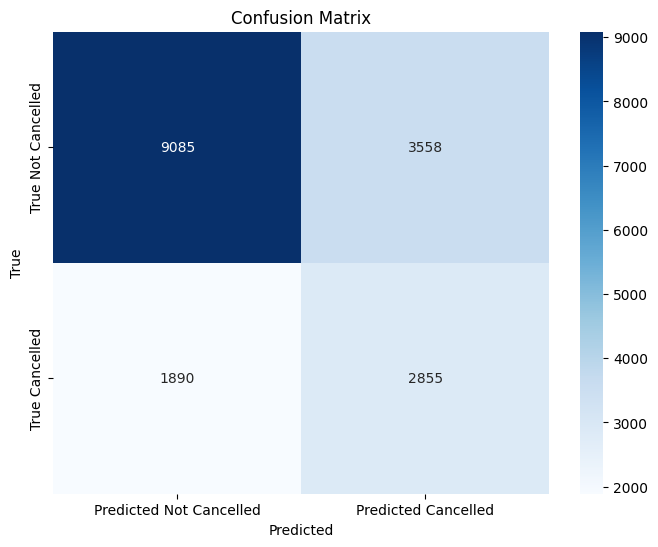

In [26]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Cancelled', 'Predicted Cancelled'], yticklabels=['True Not Cancelled', 'True Cancelled'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()